In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Comparación de modelos

"Todos los modelos están equivocados, pero algunos son útiles" George Box.

La creación de modelos es un proceso iterativo, ya sea que estemos hablando del desarrollo de teorías científicas a lo largo de décadas y con la participación de cientos o miles de personas o _modelos mínimos_ como los que realizamos cotidianamente como estimar la media de una distribución. Como vimos anteriormente este proceso iterativo se suele describir con tres pasos.

1. Crear un modelo
2. Condicionar el modelo a los datos observados 
3. Evaluar el ajuste del modelo generado a los datos y evaluar las implicancias del modelo.

Las conclusiones del paso 3 nos llevarán, posiblemente, a volver sobre los pasos 1 y 2. A veces será necesario modificar el modelo, en general expandiéndolo. Esto nos lleva a algo que, hasta ahora, hemos obviado o tratado de forma ligera, considerar la posibilidad de tener más de un modelo que ajuste los datos.

Al comparar y evaluar modelos hay que tener en cuenta que, en general, al usar un método para determinar que el modelo $A$ es mejor que el $B$, no se obtienen garantías que el modelo $A$ sea realmente un buen modelo, solo que es mejor que $B$.

A fin de ilustar algunas de las metodologías más usadas para comparar modelos vamos a empezar generando dos modelos sencillos para intentar dar cuenta de del primer conjunto de datos del cuarteto de Anscombe. Vamos a probar hacer un ajuste lineal o uno que además incluya un término cuadrático.

In [2]:
x_1 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([  8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
        10.84,   4.82,   5.68])

Las siguientes lineas sirven para crear una crear un arreglo a partir de $x_1$ cuyas dimensiones dependen del orden del polinomio a usar. Además, eleva x_1 a la potencia adecuada.

In [3]:
orden = 2
x_1p = np.vstack([x_1**i for i in range(1, orden+1)])

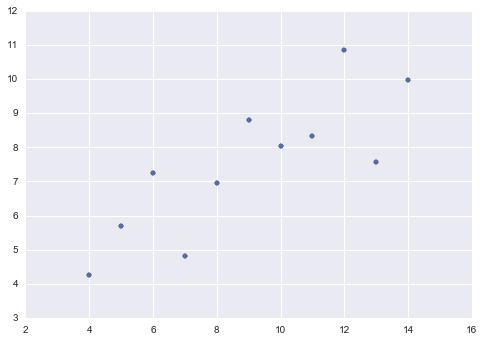

In [4]:
plt.scatter(x_1p[0], y_1);

El siguiente modelo es una regresión lineal simple y debería resultarles familiar. El único detalle es que en la linea 4 hemos pasado el argumento _transform=None_. Esto se debe a que en la actual implementación de PyMC3 el cómputo de WAIC es sensible a si las variables se transforman antes del muestreo. En este caso _epsilon_ se transforma de forma tal que en vez de quedar restringido a $[0,\infty]$ pueda variar entre $[-\infty, \infty]$ lo que facilita el muestreo.

In [5]:
with pm.Model() as modelo_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfNormal('epsilon', 10, transform=None)

    mu = alpha + beta * x_1p[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_l = pm.sample(5000, step=step, start=start)

 [-----------------100%-----------------] 5000 of 5000 complete in 5.2 sec

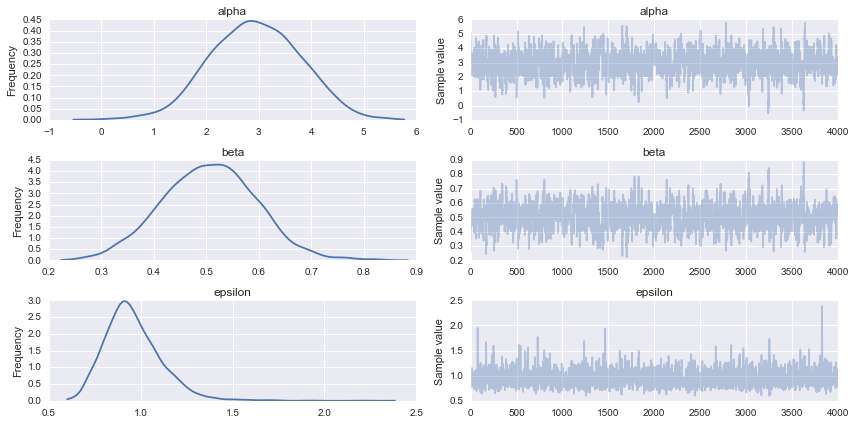

In [6]:
cadena_l = trace_l[1000::]
pm.traceplot(cadena_l, vars=[alpha, beta, epsilon]);

In [7]:
#pm.summary(cadena_l)

El segundo modelo es una extensión del primero en donde hemos agregado un término cuadrático. En la linea 6 se puede ver que hemos descripto $mu$ como $\alpha + \beta \cdot x_1p$. El producto punto es simplemente una forma abreviada de escribir la suma de los productos entre el vector de parámetros $\beta$ y el vector de datos $x\_1p$.

In [8]:
with pm.Model() as modelo_c:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfNormal('epsilon', 10, transform=None)

    mu = alpha + pm.dot(beta, x_1p)
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_c = pm.sample(5000, step=step, start=start)

 [-----------------100%-----------------] 5000 of 5000 complete in 13.7 sec

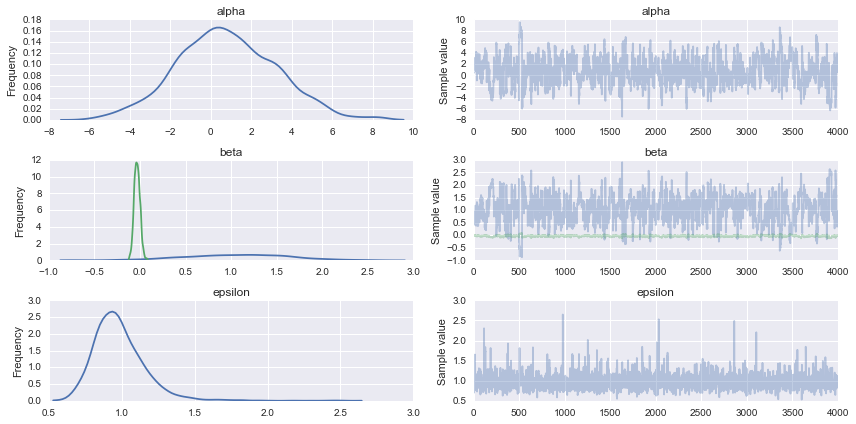

In [9]:
cadena_c = trace_c[1000::]
pm.traceplot(cadena_c, vars=[alpha, beta, epsilon]);

In [10]:
#pm.summary(cadena_c)

### Analisis del _a posteriori_

A veces es posible pensar que un modelo simple está anidado en uno más complejo, como ya hemos visto una regresión lineal es un caso especial de un polinomio de grado 2 cuando el parámetro $\beta2$ es cero:
    
$$y = \alpha + \beta_1 * x + \beta_2 * x$$

Entonces, una forma de evaluar cuan bien los datos se explican por un modelo cuadrático o lineal es observar si los valores _a posteriori_ de $\beta_2$ están _alejados_ de cero.

En la figura de abajo vemos que la contribución parece ser muy pequeña. En general (aunque esto depende del contexto del problema) una valor de $\beta_2$ entre -0.1 y 0.1, es a los fines prácticos 0. Y como se puede ver casi el 99% del _a posteriori_ está en esos valores.

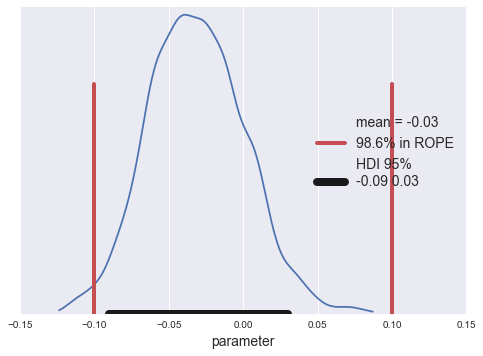

In [11]:
plot_post(cadena_c['beta'][:,1], show_mode=False, ROPE=[-0.1, 0.1]);

#### Pruebas predictivas

Como ya vimos una forma de evaluar modelos es mediante pruebas predictivas _a posteriori_, es decir evaluar en que grado el modelo es capaz de generar datos que se asemejen a los datos usados para generar el modelo. Recordemos que el principal objetivo de las pruebas predictivas _a posteriori_ no es establecer un criterio dicotómico mal-bien, correcto-incorrecto, si no algo un poco más en el medio tratando de determinar en que medida el modelo es capaz de capturar los datos y en que medida no. 

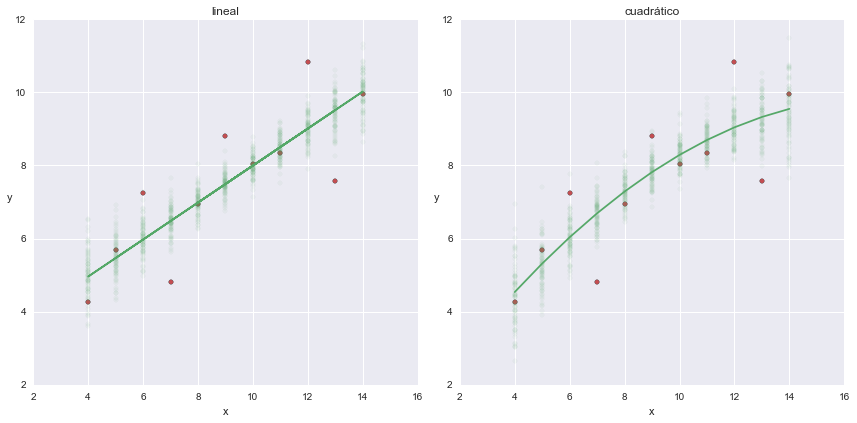

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1, y_1, c='r');
plt.ylim(2,12)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('lineal')
for i in range(0, len(cadena_l['alpha']), 50):
    plt.scatter(x_1, cadena_l['alpha'][i] + cadena_l['beta'][i]*x_1, c='g', edgecolors='g', alpha=0.05);
plt.plot(x_1, cadena_l['alpha'].mean() + cadena_l['beta'].mean()*x_1, c='g', alpha=1)

    
plt.subplot(122)
plt.scatter(x_1, y_1, c='r');
plt.ylim(2,12)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('cuadrático')
for i in range(0, len(cadena_c['alpha']), 50):
    plt.scatter(x_1, cadena_c['alpha'][i] + np.dot(cadena_c['beta'][i], x_1p), c='g', edgecolors='g', alpha=0.05)
ordenado = np.argsort(x_1)
plt.plot(x_1[ordenado], cadena_c['alpha'].mean() + np.dot(cadena_c['beta'].mean(axis=0), x_1p)[ordenado], c='g', alpha=1);

plt.tight_layout();

## Criterios de Información

Formalmente si quisieramos evaluar un modelo necesitariamos crear una medida de _exactitud predictiva_. Es decir una métrica que estime con que exactitud (o onversamente con que grado de error) el modelo es capaz de predicir datos aún no observados. Intuitivamente, esto se logra midiendo cuanto se desvía el modelo de los datos. Mientrás mejor sea el error entre datos y modelo, mejor el modelo. Pero el criterio no puede ser tan simple, ya que en principio siempre es posible obtener un mejor modelo aumentado el número de parámetros hasta que logremos que el modelo explique los datos con error cero. El modelo habrá _aprendido_ no solo la señal en los datos si no el ruido en los datos! por lo que nuestro modelo servirá solo para explicar el conjunto de datos que usamos para determinar los parámetros pero será muy malo para explicar cualquier otro conjunto de datos, es decir habremos disminuido la _exactitud predictiva_ en vez de aumentarla. Este fenómemo se llama sobreajuste (overfitting). Lo que necesitamos es un criterio que penalice de alguna forma a modelos con mayor número de parámetros. 

Los modelos Bayesianos incluyen basicamente dos términos el _likelihood_ y el _a priori_ si aumentamos el número de paráemtros el likehood se torna más flexible y lograr _acomodar_ mejor un conjunto de datos, pero al mismo tiempo cada parámetro debe tener un _a priori_ mientrás más parámetros tenga el modelo más _extendido_ será el _a priori_, es decir menos probable _a priori_ esa combinación de parámetros. Esta es la razón por la cual en muchos problemas se puede ver al _a priori_ como un término que regulariza las predicciones de forma de disminuir las chances de _overfitting_ o en general de predicciones que no tienen demasiado sentido. Esto no quiere decir que un modelo Bayesiano sea inmune a estos problemas, solo que en general son menos sensibles a estos problemas. 


La mejor forma posible (y la menos útil de todas) es estimar la _exactitud predictiva_ evaluando que tan bueno es un modelo para explicar datos no usados para generar el modelo, el problema es que esto requiere de tener muchos datos disponibles como para _darse el lujo_ de dejar información de lado. En general nunca se tiene _demasiados_ datos, por que mientras más datos tenemos más preguntas queremos contestar con esos datos, y eso implica en general subdividir los datos en sub-grupos. La segunda mejor estrategia se conoce como validación cruzada (_cross-validation_), no entraremos en demasiado detalle pero basicamente consiste en separar el conjunto de datos en $K$ grupos y usar $K-1$ grupos para ajustar el modelo y el restante para evaluarlo. Este proceso se repite varias veces (siempre dejando un grupo distinto de lado y ajustando con el resto), de esta forma se obtiene una buena estimación de la _exactitud predictiva_ del modelo. 


Idealmente las medidas de exactitud predictiva deberían estar diseñadas _ad-hoc_ para cada problema. De esta forma podríamos intentar medir de forma lo más correcta posible la relación costo-beneficio de los errores o falta de exactitud de un modelo. No deberíamos medir con el mismo rigor el riesgo de un modelo erróneo cuando estimamos la contaminación de agua consumida por humanos, que el riesgo de un modelo que estima cuanto dinero debe gastar una empresa en publicidad en radio vs televisión. El uso de funciones de costo en la toma de decisiones usando modelos Bayesianos (o de otro tipo) pertenece a un campo de estudio llamado _análisis de decisiones_, del cual no diremos más nada en el resto el curso. 

Una medida que probablemente conozcan para estimar la bondad de un modelo es el error cuadrático medio.

$$\frac{1}{n} \sum_{i=1}^{n} (y_i - E(y_i|\theta))^2$$

Es decir el error promedio, respecto de la media elevado al cuadrado. Esta medida es muy usada por su simplicidad de cáculo y de interpretación pero tiene el problema que se vuelve cada vez menos adecuada a medida que los modelos se alejan más y más de la distribución normal.

El logaritmo natural del _likelihood_ $\log (p|\theta)$ es otra medida muy usada y es proporcional al error cuadrático medio si el modelo es Gaussiano con varianza constante. En el límite de muestras de gran tamaño (cuando el _a priori_ se vuelve irrelevante) el modelo con el _log-likehood_ más grande es también el modelo con el _a posteriori_ más grande.

Por razones históricas, y con fundamentación teórica en lo que se conoce como teoría de la información. Las medidas de exactitud predictiva basadas en el _log-likelihood_ se llaman genéricamente _criterios de información_. En general se basan en medir una cantidad conocida como desviación (_deviance_):

$$\log p(y|\hat{\theta})$$

Es decir el logaritmo del _likelihood_, dado una estimación puntual de $\theta$.

La idea general detrás de todos estos criterios es que existe un trade-off entre la bondad de ajuste (que tan bien el modelo explica los datos) y la complejidad del modelo (algo asi como el número de parámetros). Dentro de los criterios de información el AIC (Akaike Information Criteria), es una medida muy usada y se define como:

$$AIC = -2 \log p(y|\hat{\theta_{mle}}) + 2k $$

Entre dos modelos se prefiere aquel con menor AIC. El primer termino es el likelihood para un valor fijo de $\theta$ (el valor máximo del likelihood, maximun likelihood estimation _mle_), al ajustar modelos es posible aumentar el valor del _likelihood_ simplemente agregando parámetros esto le da flexibilidad al modelo para ajustarse a los datos (recordemos el ejemplo de la regresión lineal a la que agregamos un término cuadrático), el problema que esto podría conducir al sobreajuste (_overfitting_). Por eso, se introduce un término que penaliza la _complejidad_ del modelo, en este caso la cantidad de parámetros a estimar $k$.

AIC es una medida útil para modelos frecuentistas, pero no sirve para modelos Bayesianos por un lado no hace uso del _a posteriori_, por el otro en modelos con estructura jerárquica o que tengan _a prioris_ informativos, el número de parámetros efectivos no es $k$ si no que debe ser estimado a partir de los datos.

Otra medida es el BIC (_Bayesian Information Criteria_), aunque no es muy Bayesiano en realidad por lo que no lo discutiremos. Una medida usada en contexto Bayesianos es el DIC (_Deviance Information Criteria_). Que en vez de usar $\log p(y|\hat{\theta_{mle}})$ usa $\log p(y|\hat{\theta_{bayes}})$, es decir usa la media del _a posteriori_ de $\theta$ y vez de $k$ usa un término que estima el número efectivo de parametros a partir de los datos.

### WAIC

Por último tenemos a WAIC (aunque en la literatura hay muchos más). WAIC se podría considerar como el sucesor de DIC, ya que es similar en ciertos aspectos pero ha demostrado ser una mejor medida. A continuación se muestra como calcularlo a partir de $S$ simulaciones de un _a posteriori_, como las obtenidas usando PyMC3, $n$ es la cantidad de datos usados para ajustar el modelo:

$$WAIC = -2 lpd + 2 p_{WAIC}$$

$$lpd = \sum_{i=1}^{n} \log \left(\frac{1}{s}  \sum_{i=1}^{s}p(y_i|\theta^s)\right)$$

$$p_{WAIC} = \sum_{i=1}^{n} v_{s=1}^S (\log p(y_i|\theta^s))$$

El primer término, lpd, se calcula de la siguiente forma para cada dato se calcula la media del _likelihood_ a lo largo de los $S$ _pasos_ de la simulación luego a esas medias se les calcula el logaritmo y por último se suma sobre los $n$ datos. Para el término $p_{WAIC}$ el cálculo es parecido solo que en vez de calcular las medias de los _likelihoods_ se calcula la varianza de los _log-likelihood_. Como en los otros criterios de información el primer término tiene relación con el buen ajuste del los datos por parte del modelo (aumenta a medida que el ajuste mejora) y el segundo estima el número de parámetros efectivos (aumenta a medida que la _complejidad_ del modelo aumenta).

In [13]:
pm.waic(cadena_l, modelo_l), pm.waic(cadena_c, modelo_c)

(41.782114684503483, 43.354213552244907)

## Factores de Bayes

Una alternativa, muy usado para evaluar modelos, y quizá una de las que levanta mayores discusiones en los círculos Bayesianos el es uso de los llamados factores de Bayes. Los detractores del uso de los factores de Bayes argumentan que los factores de Bayes pueden ser muy sensibles a la elección de _a priori_, especialmente cuando se usan _a prioris_ poco informativos. No sensibles en el sentido que influyen en la estimación de parámetros (como hemos visto y que no es un problema) si no sensibles al punto de hacer inestables o poco confiables el resultado de los factores de Bayes. Además, el computo de los factores de Bayes para un modelo es más dificil y costoso que la estimación de los parámetros para ese modelo, en general el costo es un orden de magnitud superior. Otra crítica a los factores de Bayes es que pueden ser usados para hacer pruebas de hipótesis similares a las realizadas con métodos frecuentistas, el problema en estos casos es que estas pruebas de hipótesis sufren de muchos de los mismos que las pruebas hechas por medios frecuentistas (sol oque disfrazadas de Bayesianas), sumado al problema que ya dijimos sobre el computo costoso y la _inestabildiad_ propia de los factores de Bayes. Habiendo hecho todas estas aclaraciones (y teniendo en cuenta otras como  [esta](http://doingbayesiandataanalysis.blogspot.co.at/2015/12/lessons-from-bayesian-disease-diagnosis.html) o [esta otra](http://www.stat.columbia.edu/%7Egelman/research/published/avoiding.pdf)) pasemos a ver que son y como se calculan los factore de Bayes.

En general el teorema de Bayes se escribe como:

$$
p(\theta|y) = {\frac {p(y|\theta)p(\theta)}{p(y)}}
$$

donde $y$ son los datos y $\theta$ los parámetros o en general las hipótesis. Alternativamente podríamos escribirlo de la siguiente forma:


$$p(\theta|y, M) = {\frac {p(y|\theta, M)p(\theta|M)}{p(y|M)}}$$

La única diferencia entre la primer y segunda forma es que en la segunda se hace explícita la dependencia de la inferencia de un modelo $M$. El término del denominador, es llamado _evidencia_, hasta ahora lo habíamos obviado, ya que no es necesario determinar directamente al usar métodos de meustreo como Markov Chain Monte Carlo (MCMC). Y se corresponde con la siguiente expresión:

$$p(y|M) = \int p(y|\theta, M) p(\theta|M) d\theta_m$$

Es decir para calcular la _evidencia_ $p(y|M)$ hay que marginalizar (integrar o sumar según corresponda) sobre todos los valores posibles de $p(\theta|M)$, es decir sobre todos los valores posible de $\theta$ _a priori_ para un modelo dado. El por ello que tambien se la suele llamar _likelihood marginal_.

La cantidad $p(y|M)$ en si misma no nos dice demasiado, por ello lo que se suele hacer cuando se quiere comparar dos modelos es tomar el cociente de la evidencia para cada modelo y esto es lo que se conoce como factor de Bayes.

$$F_b = \frac{p(y|M_0)}{p(y|M_1)}$$

Si $F_b > 1$ entonces el modelo 0 explica los datos mejor que el modelo 1.

Algunos autores (como [Jeffreys](https://books.google.com/books?id=vh9Act9rtzQC&printsec=frontcover#v=onepage&q&f=false) y [Kass y Raftery](http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476572)) han propuesta tablas con rangos para interpretar los factores de Bayes del estilo de: 

* 1-5 "apenas vale la pena mencionar"
* 5-10 "importante/sustancial"
* 10-15 "fuerte"
* 15-20 "muy fuerte"
* $>$ 20 "decisivo"

o puntos de corte como si $F_b > 3$ el modelo 0 es _sustancialmente_ mejor que el 1, o de forma equivalente si $F_b < \frac{1}{3}$ el modelo 1 es _sustancialmente_ mejor que el 0. Estos criterios no son _reglas automáticas_ son guías que pueden llegar a ser útiles, pero la mejor aproximación es siempre poner los resultados numéricos en el contexto del problema, reportando la mayor cantidad de detalles posibles de forma que terceros puedan sacar sus propias conclusiones. 

El computo de los factores de Bayes y la comparación entre modelos se puede pensar como un modelo Bayesiano jerárquico en el cual el parámetro de interés a determinar y el que está más arriba en la jerarquía es un índice asociado a cada modelo que se compara. Es decir, haremos inferencia sobre los dos modelos en paralelo y podremos una variable discreta que visitará de forma alternada uno u otro modelo. La cantidad de veces que esta variable visita un modelo es proporcional a la probabilidad de ese modelo $p(M_x|y)$, para calcular el factor de Bayes deberemos hacer lo siguiente:

$$\frac{p(y|M_0)}{p(y|M_1)} = \frac{p(M_0|y)}{p(M_1|y)}  \frac{p(M_1)}{p(M_0)}$$

El primer término a la derecha de la igualdad es el _posterior odds_ y el segundo es el _a priori_ (_priors odds_). Esta ecuación es tan solo una consecuencia de escribir el teorema de Bayes para el cociente entre p(y|M_0) y p(y|M_1).

In [14]:
with pm.Model() as modelo_comb0:
    p = [0.5, 0.5]
    model_index = pm.Categorical('model_index', p=p)

    alpha0 = pm.Normal('alpha0', mu=0, sd=10)
    alpha1 = pm.Normal('alpha1', mu=0, sd=10)
    beta0 = pm.Normal('beta0', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10, shape=2)
    epsilon = pm.HalfNormal('epsilon', 10, transform=None)
    
    mu_0 = alpha0 + pm.dot(beta0, x_1p[0])
    mu_1 = alpha1 + pm.dot(beta1, x_1p)
    
    mu = pm.switch(pm.eq(model_index, 0), mu_0, mu_1)
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1)
    
    start = pm.find_MAP()
    step1 = pm.ElemwiseCategoricalStep(var=model_index, values=[0, 1])
    step2 = pm.Metropolis([alpha0, alpha1, beta0, beta1, epsilon])
    trace_comb0 = pm.sample(10000, step=[step1, step2], start=start)

 [-----------------100%-----------------] 10000 of 10000 complete in 10.0 sec

(0.9976666666666667, 0.0023333333333333335, 427.57142857142856)

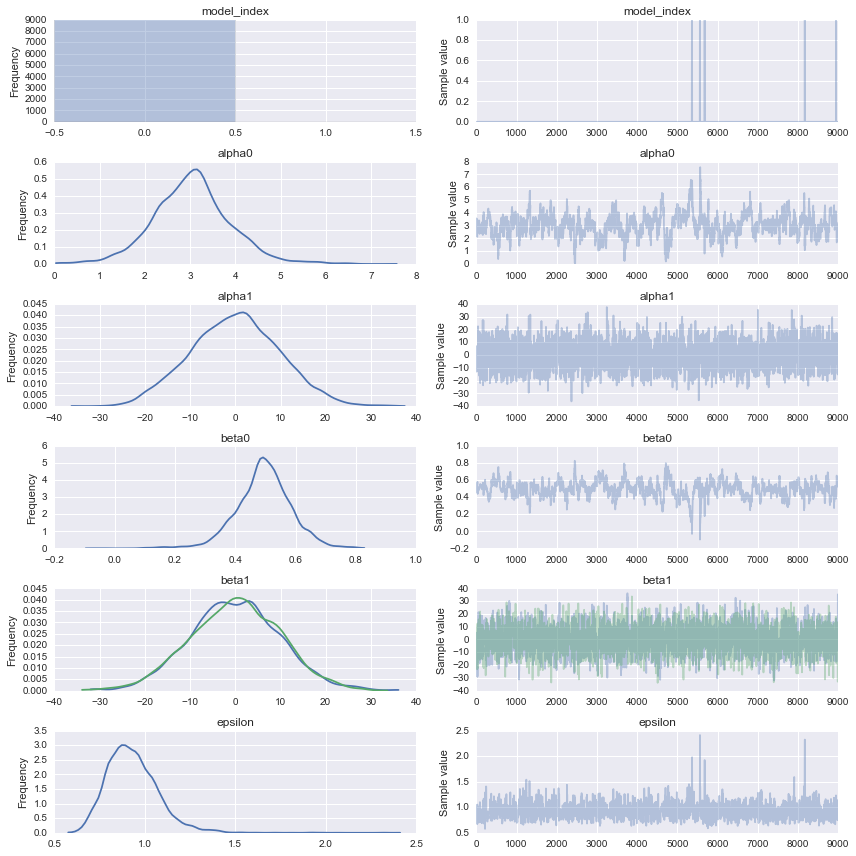

In [15]:
cadena_comb0 = trace_comb0[1000::]
pm.traceplot(cadena_comb0);
pM1 = cadena_comb0['model_index'].mean()
pM0 = 1 - pM1
pM0, pM1, (pM0/pM1)*(p[1]/p[0])

El modelo 0 es infinitamente mejor que el modelo 1. Esto es bastante sospechoso. Como podemos ver lo que sucede es que estamos muestreando el modelo 0 muchas veces y el modelo 1 nunca (o muy pocas) veces. Esto sucede por dos razones, primero el modelo 0 es efectivamente el modelo que mejor explica los datos, segundo tenemos un problema de muestreo! Lo que sucede es que en cada paso los valores de los parámetros se actualizan, aún los de los parámetros que NO se usan para modelar los datos. Es decir al elegir el modelo 0 los parámetros del modelo 1 también se actualizan pero como no se usan para explicar los datos quedan restringidos solo por el _a priori_ si este es muy vago es posible que para cuando el modelo 1 sea elegido estos valores estén muy lejos de los nuevos valores propuestos y entonces el paso es rechazado. 

Hay dos cosas que se pueden hacer  para favorecer el muestreo del modelo menos favorable:

1. Elegir los _a prioris_ para los modelos de forma tal que sea favorecido el _peor_ modelo. Idealmente el mejor muestreo se obtendría si la mitád del tiempo se muestrea cada modelo. El único recaudo al hacer esto es incluir los _a prioris_ en el cálculo del factor de Bayes (en vez de asumir que los _a prioris_ son idénticos). Esta es la opción más simple y en muchos casos es suficiente).

2. Usar _pseudo a prioris_, la idea es simple. Si el problema es que los parámetros se mueven libremente cuando no son usados para restringir los datos, entonces lo que se puede hacer es dejarlos más o menos fijos en algún valor mientras no se usen para describir los datos (es decir cuando el otro modelo esta siendo visitado por el algoritmo de muestreo) y asignarles el _a priori_ correcto cuando el modelo que describen sea el elegido. ¿Cómo elejir en que valor dejarlos fijos? Lo más razonable es que el _pseudo a prioris_ tome valores cercanos al _a posteriori_. Como el _a posteriori_ es deconocido lo que se hace es correr los modelos por separado, determinar el _a priori_ y luego usar esos valores para fijar los _pseudo a prioris_.

A continuación haremos ambas cosas los _a prioris_ para el índice del modelo los fijaremos de forma tal de favorecer al modelo 1 sobre el 0. Además fijaremos los _pseudo a prioris_ a valores tomados de los modelos individuales que evaluamos al principio de la notebook. Para alternar entre un _pseudo a priori_ y el _a priori_ correcto usaremos ```pm.switch``` y ```pm.eq``` al igual que usabamos para alternar entre modelos.

In [16]:
#pm.summary(cadena)

In [17]:
with pm.Model() as model:
    p = [0.3, 0.7]
    model_index = pm.Categorical('model_index', p=p)

    ###########      pseudo priors  ###################
    alpha0_sd = pm.switch(pm.eq(model_index, 0), 10, 1) # el mismo para beta0_sd
    alpha0_mu = pm.switch(pm.eq(model_index, 0), 0, 3)
    beta0_mu = pm.switch(pm.eq(model_index, 0), 0, 0.5)
  
    alpha1_mu = pm.switch(pm.eq(model_index, 0), 0.5, 0)
    alpha1_sd = pm.switch(pm.eq(model_index, 0), 1, 10) # el mismo para beta1_sd y beta2_sd
    
    beta1_mu = pm.switch(pm.eq(model_index, 0), 1, 0)    
    ####################################################
    
    alpha0 = pm.Normal('alpha0', mu=alpha0_mu, sd=alpha0_sd)
    beta0 = pm.Normal('beta0', mu=beta0_mu, sd=alpha0_sd)
    alpha1 = pm.Normal('alpha1', mu=alpha1_mu, sd=alpha1_sd)
    beta1 = pm.Normal('beta1', mu=beta1_mu, sd=alpha1_sd)
    beta2 = pm.Normal('beta2', mu=0, sd=alpha1_sd)
    
    epsilon = pm.HalfNormal('epsilon', 10, transform=None)

    mu_0 = alpha0 + pm.dot(beta0, x_1p[0])
    mu_1 = alpha1 + beta1 * x_1p[0] + beta2 * x_1p[1] 
    
    mu = pm.switch(pm.eq(model_index, 0), mu_0, mu_1)
    
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1)
    
    start = pm.find_MAP()
    step1 = pm.ElemwiseCategoricalStep(var=model_index, values=[0, 1])
    step2 = pm.Metropolis([alpha0, alpha1, beta0, beta1, beta2, epsilon])
    trace = pm.sample(50000, step=[step1, step2], start=start)

 [-----------------100%-----------------] 50000 of 50000 complete in 54.0 sec

(0.66506122448979599, 0.33493877551020407, 4.6331139816394522)

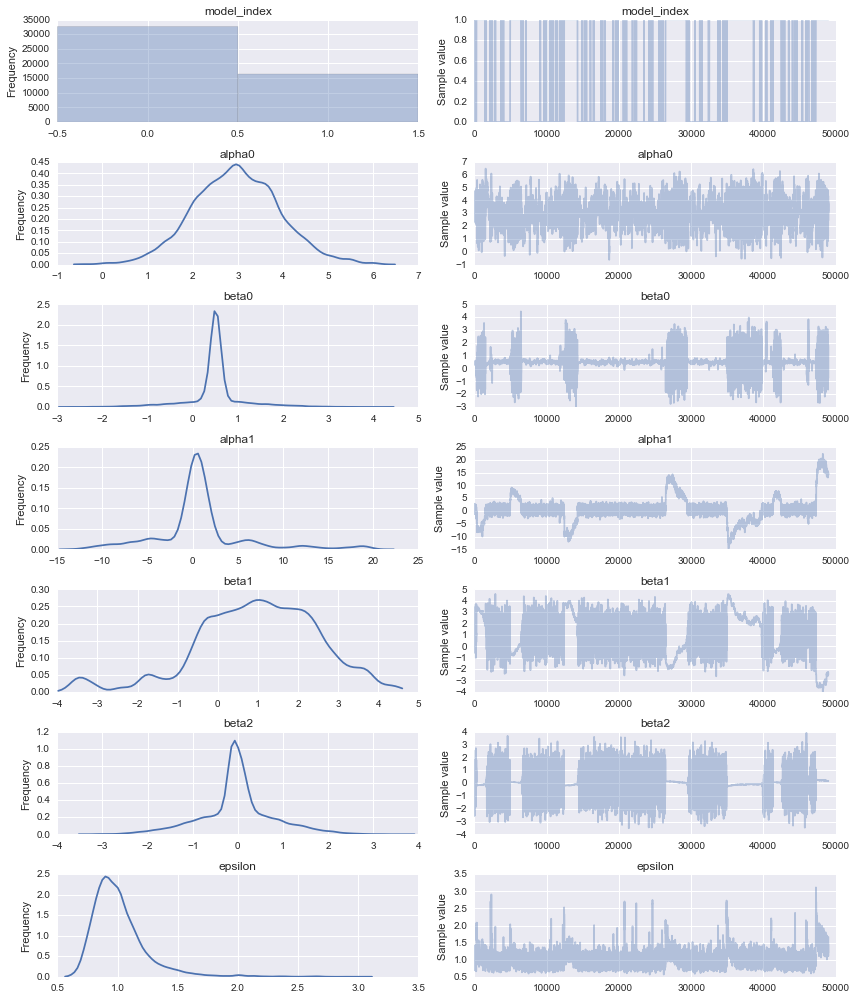

In [18]:
cadena = trace[1000::]
pm.traceplot(cadena);
pM1 = cadena['model_index'].mean()
pM0 = 1 - pM1
pM0, pM1, (pM0/pM1)*(p[1]/p[0])

COmo puede verse el anterior modelo tambien tiene problemas las razones son... COMPLETAR!!!

A partir de la definición de factor de Bayes resulta tentador calularlos directamente como la media de los _likelihoods_ promediado a lo largo de toda la simulación. El problema es que esta aproximación (conocida como el método de la media harmónica) está sesgado y sobreestima el verdadero valor de $p(y|M)$. Intuitivamente esto se puede ver en el caso de un modelo que usa un _a priori_ no informativo o ligeramente informativo y donde el _a posteriori_ está dominado por el _likelihood_. En tal caso la mayoría de las muestras del MCMC provendrán de partes del _a posteriori_ donde el _likelihood_ tiene valores altos y muy poco de lugares donde el _likelihood_ tiene valores bajos. Es decir este método tiene problemas para muestrear adecuadamente las _colas_ de las distribuciones, lo que se traduce en problemas para estimar la evidencia.

A pesar de lo antedicho el método de la media harmónica sigue siendo muy usado (principalmente por su simplicidad de calculo e interpretación y a pesar de sus conocidos problemas). Como alternativa se han planteado varias opciones, desde no usar los factores de Bayes (o al menos no darles mucha importancia) hasta métodos de muestreo especializados en calcular la _evidencia_.

En PyMC3, podríamos calcular los factores de Bayes usando: 

In [19]:
l_M_0 = np.exp(np.array([modelo_l.logp(pt) for pt in trace_l])).mean()
l_M_1 = np.exp(np.array([modelo_c.logp(pt) for pt in trace_c])).mean()
l_M_0/l_M_1

22.554961563790702

In [20]:
#pm.summary(cadena)

### EXTENDER
Ahora repetiremos los ejercicios anteriores con un modelo un poco mejor comportado y muy conocido por nosotros las monedas! 

In [22]:
monedas = 30
caras =  15 
y = np.repeat([0, 1], [monedas-caras, caras])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [23]:
with pm.Model() as model:
    p = [0.5, 0.5]
    model_index = pm.Categorical('model_index', p=p)

    omega = [.25, .75]
    kappa = 12
    
    m_0 = (omega[0]*(kappa-2)+1 , (1-omega[0])*(kappa-2)+1)
    m_1 = (omega[1]*(kappa-2)+1 , (1-omega[1])*(kappa-2)+1)
    m = pm.switch(pm.eq(model_index, 0), m_0, m_1)

    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y)
    
    start = pm.find_MAP()
    step0 = pm.ElemwiseCategoricalStep(var=model_index,values=[0,1])
    step1 = pm.Metropolis([theta])
    trace = pm.sample(5000, step=[step0, step1], start=start)  

 [-----------------100%-----------------] 5000 of 5000 complete in 2.3 sec

(0.50449999999999995, 0.4955, 1.0181634712411705)

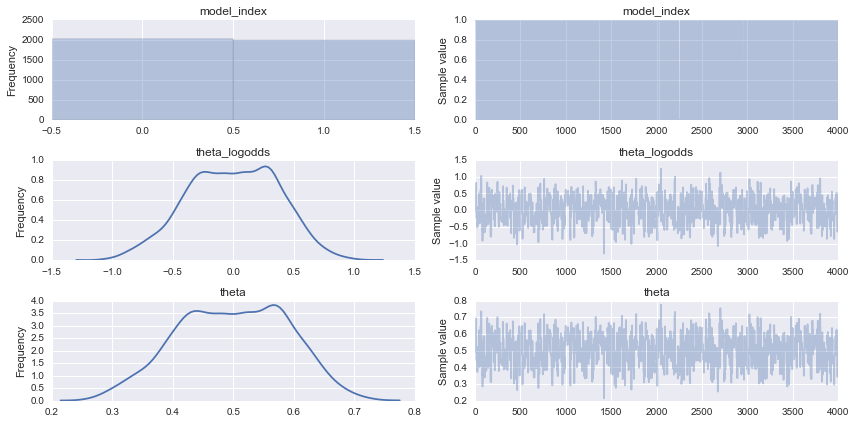

In [34]:
cadena = trace[1000::]
pm.traceplot(cadena)
pM1 = cadena['model_index'].mean()
pM0 = 1 - pM1
pM0, pM1, (pM0/pM1)*(p[1]/p[0])

In [25]:
with pm.Model() as model0:
    omega = .25
    kappa = 20
    
    m = (omega*(kappa-2)+1 , (1-omega)*(kappa-2)+1)

    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace0 = pm.sample(5000, step, start=start)  

 [-----------------100%-----------------] 5000 of 5000 complete in 0.6 sec

In [26]:
with pm.Model() as model1:
    omega = .75
    kappa = 20
    
    m = (omega*(kappa-2)+1 , (1-omega)*(kappa-2)+1)

    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace1 = pm.sample(5000, step, start=start)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.6 sec

In [30]:
pm.waic(trace0, model0), pm.waic(trace1, model1)

/usr/local/lib/python3.5/dist-packages/pymc3/stats.py:112: UserWarning: 
            WAIC estimates are biased for models that include transformed random variables.
            See https://github.com/pymc-devs/pymc3/issues/789.
            The following random variables are the result of transformations:
            theta_logodds
        
  """.format(', '.join(rv.name for rv in transformed_rvs)))
/usr/local/lib/python3.5/dist-packages/pymc3/stats.py:112: UserWarning: 
            WAIC estimates are biased for models that include transformed random variables.
            See https://github.com/pymc-devs/pymc3/issues/789.
            The following random variables are the result of transformations:
            theta_logodds
        
  """.format(', '.join(rv.name for rv in transformed_rvs)))


(43.983455544850052, 43.882349669740861)

In [32]:
l_m1 = np.exp(np.array([model0.logp(pt) for pt in trace0[1000:]])).mean()
l_m2 = np.exp(np.array([model1.logp(pt) for pt in trace1[1000:]])).mean()
l_m1/l_m2

0.98675257994106258

## Para seguir leyendo

* Más sobre modelos generalizados lineales en:
    * Capítulo 10 de Doing Bayesian Data Analysis de Kruschke (2 [edición](www.amazon.com/gp/product/0124058884))
    * Capítulos 6 y 7 de [Bayesian Data Analysis](www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954) de Andrew Gelman


* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)   

In [35]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo Ubuntu 15.10 y usando:
Python 3.5.0
IPython 4.0.0
PyMC3 3.0
NumPy 1.10.1
SciPy 0.16.1
Matplotlib 1.5.0
Seaborn 0.6.0

